# VGG-16

Importation du modèle VGG-16


In [1]:
import os
%cd
from keras.applications.vgg16 import VGG16,preprocess_input

model = VGG16( include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              classifier_activation='softmax'
             ) # Création du modèle VGG-16 implementé par Keras


/home/fedecabre


/home/fedecabre


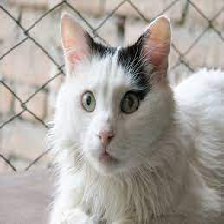

In [2]:
%cd
# à la racine pour avoir accès aux datas
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

project_path ='Documents/OC_Ingenieur_ML/P6_Classez_des_images/'
img = load_img(project_path+'data/cat.jpeg', target_size=(224, 224))  # Charger l'image
display(img)

img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
y = model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

In [5]:
from keras.applications.vgg16 import decode_predictions

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=3)[0])

Top 3 : [('n02124075', 'Egyptian_cat', 0.25156984), ('n02127052', 'lynx', 0.19743551), ('n01877812', 'wallaby', 0.16383485)]


# Transfert Learning


## Création du dataset

In [10]:
import os
import numpy as np
import imageio
from xml.dom import minidom
from PIL import Image

def make_dataset_race(folder,image_size=224, num_channels = 3,preprocess=True):
    image_files=os.listdir(project_path+folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size,num_channels), dtype=np.float32)
    num_images = 0
    for image in image_files:
        image_file = project_path+folder+'/'+image
        image_data = imageio.imread(image_file)
        if image_data.shape[2]==num_channels: # on prend que les images avec 3 channels
            annon_file = project_path+'data/Annotation' + '/' + folder.split('/')[-1] + '/' + image.split('.')[0]
            annon_xml = minidom.parse(annon_file)
            xmin = int(annon_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
            ymin = int(annon_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
            xmax = int(annon_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
            ymax = int(annon_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)
            new_image_data = image_data[ymin:ymax,xmin:xmax,:]

            #bounding carré rempli de noir
            x = xmax-xmin
            y = ymax-ymin
            if x<y:
                squarre_image = np.zeros((y,y,num_channels))
                delta = ((y-x)//2)
                squarre_image[:new_image_data.shape[0],delta:(new_image_data.shape[1])+delta,:] = new_image_data
                squarre_image = squarre_image.astype(np.uint8)
            if x>y:
                squarre_image = np.zeros((x,x,num_channels))
                delta = ((x-y)//2)
                squarre_image[delta:(new_image_data.shape[0]+delta),:new_image_data.shape[1],:] = new_image_data
                squarre_image = squarre_image.astype(np.uint8)

            new_image = Image.fromarray(squarre_image)
            new_image = new_image.resize(size=(image_size,image_size))
            crop_dir = project_path+'data/Cropped/'+ folder.split('/')[-1]
            if os.path.exists(project_path+'data/Cropped/') is False:
                os.mkdir(project_path+'data/Cropped/')
            if os.path.exists(crop_dir) is False:
                os.mkdir(crop_dir)
            #new_image.save(crop_dir+'/'+image)  # Enregistrer les images cropés
            if preprocess:
                dataset[num_images, :, :, :] = preprocess_input(np.array(new_image,dtype='float32'))
            else:
                dataset[num_images, :, :, :] = np.array(new_image,dtype='float32')
            num_images = num_images + 1
    dataset = dataset[0:num_images, :, :, :]
    print('Full dataset tensor:', dataset.shape)
    return dataset


In [11]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.zeros((nb_rows,img_size, img_size,num_channels), dtype=np.float32)
        labels = np.zeros((nb_rows,), dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

In [12]:
images_folders_path = "data/Images/"
images_folders=os.listdir(project_path+images_folders_path)

num_classes = 20 #len(images_folders)
train_size  = 2000
valid_size  = 1000
image_size  = 224 # 90 ça fonctionne pour whitenning
num_channels= 3
preprocess = False

# Création des datasets vides
valid_dataset, valid_labels = make_arrays(valid_size, image_size)
train_dataset, train_labels = make_arrays(train_size, image_size)


vsize_per_class = valid_size // num_classes # il peut être NULL
tsize_per_class = train_size // num_classes

start_v, start_t = 0, 0
end_v, end_t = vsize_per_class, tsize_per_class
end_l = vsize_per_class+tsize_per_class

# make a dictionary
dog_race_dict = dict()

for label,folder in enumerate(images_folders):
    if label < num_classes :
        print(str(label+1)+'/'+str(num_classes)+' - '+folder.split('-')[-1])
        dog_race_dict[folder.split('-')[-1]] = label
        dataset_race = make_dataset_race('data/Images/'+folder,image_size=image_size,preprocess=preprocess)
        train_breed = dataset_race[vsize_per_class:end_l, :, :, :]
        train_dataset[start_t:end_t, :, :, :] = train_breed
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
        if valid_dataset is not None:
            valid_breed = dataset_race[:vsize_per_class, :, :, :]
            valid_dataset[start_v:end_v, :, :, :] = valid_breed
            valid_labels[start_v:end_v] = label
            start_v += vsize_per_class
            end_v += vsize_per_class

dog_race_invert_dict = {v: k for k, v in dog_race_dict.items()}

1/20 - Bedlington_terrier
Full dataset tensor: (182, 224, 224, 3)
2/20 - collie
Full dataset tensor: (153, 224, 224, 3)
3/20 - Greater_Swiss_Mountain_dog
Full dataset tensor: (168, 224, 224, 3)
4/20 - bull_mastiff
Full dataset tensor: (156, 224, 224, 3)
5/20 - flat_coated_retriever
Full dataset tensor: (152, 224, 224, 3)
6/20 - Leonberg
Full dataset tensor: (210, 224, 224, 3)
7/20 - affenpinscher
Full dataset tensor: (150, 224, 224, 3)
8/20 - English_foxhound
Full dataset tensor: (157, 224, 224, 3)
9/20 - kuvasz
Full dataset tensor: (150, 224, 224, 3)
10/20 - tan_coonhound
Full dataset tensor: (159, 224, 224, 3)
11/20 - bloodhound
Full dataset tensor: (187, 224, 224, 3)
12/20 - Norfolk_terrier
Full dataset tensor: (172, 224, 224, 3)
13/20 - Great_Pyrenees
Full dataset tensor: (213, 224, 224, 3)
14/20 - haired_pointer
Full dataset tensor: (152, 224, 224, 3)
15/20 - Tzu
Full dataset tensor: (214, 224, 224, 3)
16/20 - Australian_terrier
Full dataset tensor: (196, 224, 224, 3)
17/20 - Rott

In [13]:
dog_race_dict

{'Bedlington_terrier': 0,
 'collie': 1,
 'Greater_Swiss_Mountain_dog': 2,
 'bull_mastiff': 3,
 'flat_coated_retriever': 4,
 'Leonberg': 5,
 'affenpinscher': 6,
 'English_foxhound': 7,
 'kuvasz': 8,
 'tan_coonhound': 9,
 'bloodhound': 10,
 'Norfolk_terrier': 11,
 'Great_Pyrenees': 12,
 'haired_pointer': 13,
 'Tzu': 14,
 'Australian_terrier': 15,
 'Rottweiler': 16,
 'Tibetan_terrier': 17,
 'Eskimo_dog': 18,
 'Maltese_dog': 19}

In [10]:
print(train_dataset.shape)
print(train_labels.shape)
print(valid_dataset.shape)
print(valid_labels.shape)

(2000, 224, 224, 3)
(2000,)
(1000, 224, 224, 3)
(1000,)


In [11]:
#train_labels_one_hot = np.zeros((train_labels.size, train_labels.max()+1))
#train_labels_one_hot[np.arange((train_labels.size),train_labels)]=1
#train_labels_one_hot.shape

from keras.utils.np_utils import to_categorical

train_labels_categorical = to_categorical(train_labels, num_classes=num_classes)
valid_labels_categorical = to_categorical(valid_labels, num_classes=num_classes)
print(train_labels_categorical.shape)
print(valid_labels_categorical.shape)

(2000, 20)
(1000, 20)


In [12]:
#on garde une copie du dataset pour l'utiliser pour le whitening
train_dataset_white = train_dataset.copy()
valid_dataset_white = valid_dataset.copy()
train_dataset_CLAHE = train_dataset.copy()
valid_dataset_CLAHE = valid_dataset.copy()

In [13]:
# on traite les datasets avec le preproces de VGG16
preprocess_input(train_dataset)
preprocess_input(valid_dataset)

array([[[[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ]],

        [[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ]],

        [[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ]],

        ...,

        [[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -1

## Whitening entraînement

In [14]:
from skimage.transform import resize

def zca_whitening_dataset(X,subset,factor=4,make_matrix=True,U=None,S=None,V=None):
    """
    Function to compute ZCA whitening in an array of images (aka Mahalanobis whitening).
    INPUT:  X: [N,img_len,img_len,channels] matrix.
            subset : numbers of elements of X to use in calculation
            factor : in order to be able to make the calculation in limited RAM the images are resized
            make_matrix : if the U, S and V matrix are already calculated
    OUTPUT: X_ZCA_rescaled_resized: [N,img_len,img_len,channels] matrix with the same shape of X
            U: [M x M] eigenvectors of sigma.
            S: [M x 1] eigenvalues of sigma.
            V: [M x M] transpose of U 
    """
    print(X.shape)
    X = X[:subset]
    print(X.shape)
    
    # reduction de dimension pour que le calcul puisse se faire avec 16 Gb de RAM
    X_resized = np.zeros((X.shape[0],X.shape[1]//factor,X.shape[2]//factor,X.shape[3]))
    for i in range(len(X)):
        X_resized[i] = resize(X[i], (X.shape[1]//factor,X.shape[2]//factor))
    print(X_resized.shape)
    X_resized = X_resized.reshape(X_resized.shape[0], 
                                  X_resized.shape[1]*X_resized.shape[2]*X_resized.shape[3])
    print(X_resized.shape)
    X_resized_norm = X_resized / 255.
    print( 'X.min()', X_resized_norm.min())
    print( 'X.max()', X_resized_norm.max())
    
    X_resized_norm.mean(axis=0).shape #This gives us values which is the number of means — one per pixel.
    X_resized_norm = X_resized_norm - X_resized_norm.mean(axis=0)
    if make_matrix:
        cov = np.cov(X_resized_norm, rowvar=False) # it will use the columns as variables (or features) and the rows as observations.
        print(cov.shape)

        U,S,V = np.linalg.svd(cov)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    print(U.shape, S.shape)
    
    # elargir les matrices pour transformer les images
    #U = resize(U, (224*224*3, 224*224*3))
    #S = resize(S, (224*224*3, 1))
    #V = resize(V, (224*224*3, 224*224*3))
    # Imposible MemoryError: Unable to allocate 169. GiB for an array with shape (150528, 150528) and data type float64
    
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    
    # ZCA Whitening matrix: U * Lambda * U'
    X_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(X_resized_norm.T).T 
    X_ZCA_rescaled = ((X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min()))*255
    print(X_ZCA_rescaled.shape)
    X_ZCA_rescaled = X_ZCA_rescaled.reshape(X.shape[0],
                                            X.shape[1]//factor,
                                            X.shape[2]//factor,
                                            X.shape[3])
    print(X_ZCA_rescaled.shape)
    X_ZCA_rescaled_resized = np.zeros(X.shape)
    for i in range(len(X)):
        X_ZCA_rescaled_resized[i] = resize(X_ZCA_rescaled[i], (X.shape[1],X.shape[2]))
    print('min:', X_ZCA_rescaled_resized.min())
    print('max:', X_ZCA_rescaled_resized.max())
    return X_ZCA_rescaled_resized,U,S,V

In [15]:
# Géneration de la matrice --> 10 minutes de calcul
_ ,U,S,V = zca_whitening_dataset(train_dataset,1000,factor=4)

(1000, 224, 224, 3)
(1000, 224, 224, 3)
(1000, 56, 56, 3)
(1000, 9408)
X.min() -0.48501960903990504
X.max() 0.5923960966222427
(9408, 9408)
(9408, 9408) (9408,)
(1000, 9408)
(1000, 56, 56, 3)
min: 11.987686136674434
max: 238.30805684054442


# Modèle VGG-16

## Fonction métriques

In [6]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
def min_loss_max_acc(model_info):
    loss_min = min(model_info.history['val_loss'])
    loss_min_epoch = model_info.history['val_loss'].index(loss_min)+1
    acc_max = max(model_info.history['val_accuracy'])
    acc_max_epoch = model_info.history['val_accuracy'].index(acc_max)+1
    return np.round(loss_min,decimals=5), loss_min_epoch, np.round(acc_max,decimals=5), acc_max_epoch

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
def clas_report(model,valid_dataset,valid_labels,dog_race_dict=dog_race_dict):
    # Classification Report
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    print('Classification Report')
    print(classification_report(valid_labels, valid_labels_pred, target_names=dog_race_dict.keys()))

In [15]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def conf_matr(model,valid_dataset,valid_labels,dog_race_dict=dog_race_dict):
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    array = confusion_matrix(valid_labels, valid_labels_pred)
    df_cm = pd.DataFrame(array, index = [i for i in dog_race_dict.keys()],
                      columns = [i for i in dog_race_dict.keys()])
    plt.figure(figsize = (15,13)).patch.set_facecolor('w')
    sn.heatmap(df_cm, annot=True)

In [16]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve,auc,roc_auc_score

def multiclass_roc_auc_score(model,valid_dataset, valid_labels, labels,dog_race_dict=dog_race_dict, average="macro"):
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8),)
    fig.patch.set_facecolor('w')
    lb = LabelBinarizer()
    lb.fit(valid_labels)
    y_test = lb.transform(valid_labels)
    y_pred = lb.transform(valid_labels_pred)

    for (idx, c_label) in enumerate(labels): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()
    return roc_auc_score(y_test, y_pred, average=average)

## Fonctions d'affichage

In [17]:
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(project_path, "Graphs")
os.makedirs(IMAGES_PATH, exist_ok=True)

IMAGES_PATH = project_path + "Graphs/"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [18]:
import matplotlib.pyplot as plt

def plot_loss(model_info,graph_name,loss_min,tight_layout=True, fig_extension="png", resolution=300):
    loss = model_info.history['loss']
    val_loss = model_info.history['val_loss']

    epochs = range(1, len(loss) + 1)
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('w')
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss '+ graph_name+'\n'
              "num_classes = " + str(num_classes) +
              ", train_size = " + str(train_size) + 
              ", valid_size = " + str(valid_size) + '\n'
              "image_size = " + str(image_size) +
              ", num_channels = " + str(num_channels))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.axvline(x=loss_min,color='red',linestyle='--')
    fig_id=(graph_name + ' training_and_validation_accuracy'+ 
              "-num_classes=" + str(num_classes) +
              "-train_size=" + str(train_size) + 
              "-valid_size=" + str(valid_size) + 
              "-image_size=" + str(image_size) +
              "-num_channels=" + str(num_channels))
    save_fig(fig_id, tight_layout, fig_extension, resolution)
    plt.show()
    

In [19]:
plt.clf()   # clear figure

def plot_accuracy(model_info,graph_name,acc_max,tight_layout=True, fig_extension="png", resolution=300):
    acc_train = model_info.history['accuracy']
    acc_val = model_info.history['val_accuracy']
    
    epochs = range(1, len(acc_train) + 1)
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('w')
    plt.plot(epochs, acc_train, 'bo', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy '+ graph_name+'\n'
              "num_classes = " + str(num_classes) +
              ", train_size = " + str(train_size) + 
              ", valid_size = " + str(valid_size) + '\n'
              "image_size = " + str(image_size) +
              ", num_channels = " + str(num_channels))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.axvline(x=acc_max,color='red',linestyle='--')
    fig_id=(graph_name + ' training_and_validation_accuracy'+ 
              "-num_classes=" + str(num_classes) +
              "-train_size=" + str(train_size) + 
              "-valid_size=" + str(valid_size) + 
              "-image_size=" + str(image_size) +
              "-num_channels=" + str(num_channels))
    save_fig(fig_id, tight_layout, fig_extension, resolution)
    plt.show()
    

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
def plotImage(X):
    plt.figure(figsize=(6, 6))
    plt.imshow(X.reshape(image_size,image_size,3))
    plt.axis('off')
    plt.show()
    plt.close()

## Stratégie fine tunning partiel

### modèle

In [23]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Récupérer la sortie de ce réseau
x = model.output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes
F = Flatten()(x)
DL1 = Dense(30)(F)
DL2 = Dense(30)(DL1)
predictions = Dense(num_classes, activation='softmax')(DL2)

# Stratégie #2 : extraction de features
for layer in model.layers:
    layer.trainable = False

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)


Entraînement du modèle


In [24]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy",f1_m,precision_m,recall_m])

new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Entraînement

In [25]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model1_info = new_model.fit(train_dataset,train_labels_categorical,
                           epochs=15,
                           batch_size=32,
                           #verbose=2,
                           validation_data=(valid_dataset,valid_labels_categorical)
                           )

Epoch 1/15
32/32 [==============================] - 28s 639ms/step - loss: 27.4820 - accuracy: 0.6200 - f1_m: 0.6230 - precision_m: 0.6230 - recall_m: 0.6230 - val_loss: 13.3162 - val_accuracy: 0.8240 - val_f1_m: 0.8187 - val_precision_m: 0.8188 - val_recall_m: 0.8188
Epoch 2/15
32/32 [==============================] - 11s 337ms/step - loss: 3.9826 - accuracy: 0.9210 - f1_m: 0.9229 - precision_m: 0.9229 - recall_m: 0.9229 - val_loss: 8.4708 - val_accuracy: 0.9060 - val_f1_m: 0.9047 - val_precision_m: 0.9047 - val_recall_m: 0.9047
Epoch 3/15
32/32 [==============================] - 11s 337ms/step - loss: 0.6825 - accuracy: 0.9800 - f1_m: 0.9805 - precision_m: 0.9805 - recall_m: 0.9805 - val_loss: 8.0465 - val_accuracy: 0.8840 - val_f1_m: 0.8832 - val_precision_m: 0.8832 - val_recall_m: 0.8832
Epoch 4/15
32/32 [==============================] - 11s 363ms/step - loss: 0.2423 - accuracy: 0.9910 - f1_m: 0.9912 - precision_m: 0.9912 - recall_m: 0.9912 - val_loss: 7.7537 - val_accuracy: 0.900

### Résultats

Saving figure model1 val_loss min=6.47878 training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

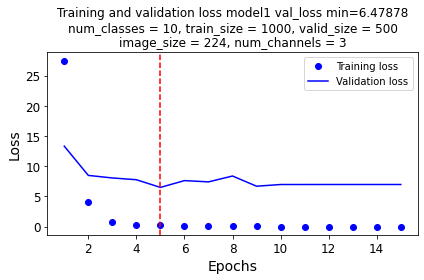

In [26]:
loss_min, loss_min_epoch, _, _ = min_loss_max_acc(model1_info)
plot_loss(model1_info,'model1 val_loss min='+str(loss_min),loss_min=loss_min_epoch)


Saving figure model1 val_acc_max=0.906 training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

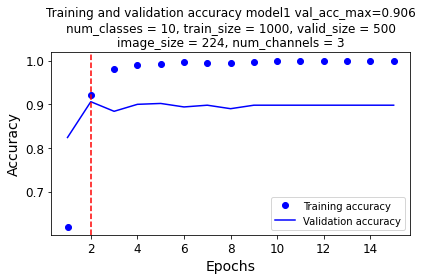

In [27]:
_, _, acc_max, acc_max_epoch = min_loss_max_acc(model1_info)
plot_accuracy(model1_info,'model1 val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


In [28]:
clas_report(new_model,valid_dataset,valid_labels)

Classification Report
                            precision    recall  f1-score   support

        Bedlington_terrier       0.84      0.98      0.91        50
                    collie       0.91      0.84      0.87        50
Greater_Swiss_Mountain_dog       0.88      0.86      0.87        50
              bull_mastiff       0.90      0.90      0.90        50
     flat_coated_retriever       0.85      0.92      0.88        50
                  Leonberg       0.93      0.86      0.90        50
             affenpinscher       0.98      0.96      0.97        50
          English_foxhound       0.86      0.84      0.85        50
                    kuvasz       0.98      0.90      0.94        50
             tan_coonhound       0.87      0.92      0.89        50

                  accuracy                           0.90       500
                 macro avg       0.90      0.90      0.90       500
              weighted avg       0.90      0.90      0.90       500



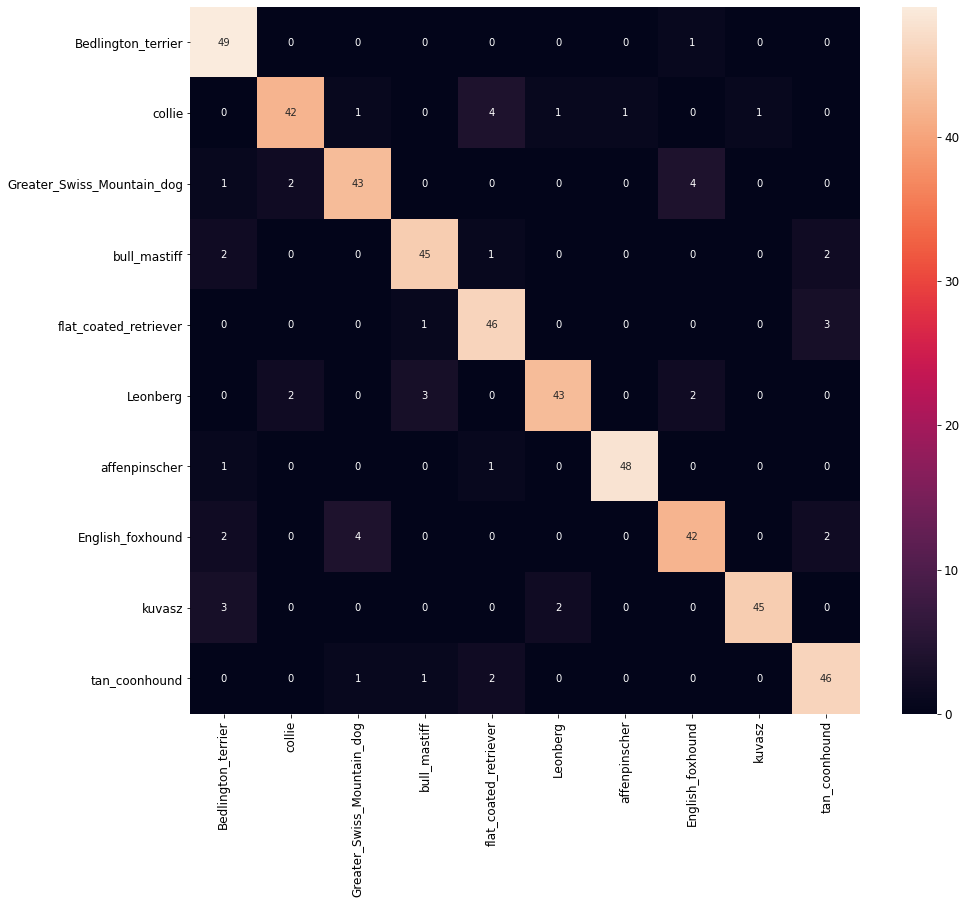

In [29]:
conf_matr(new_model,valid_dataset,valid_labels)

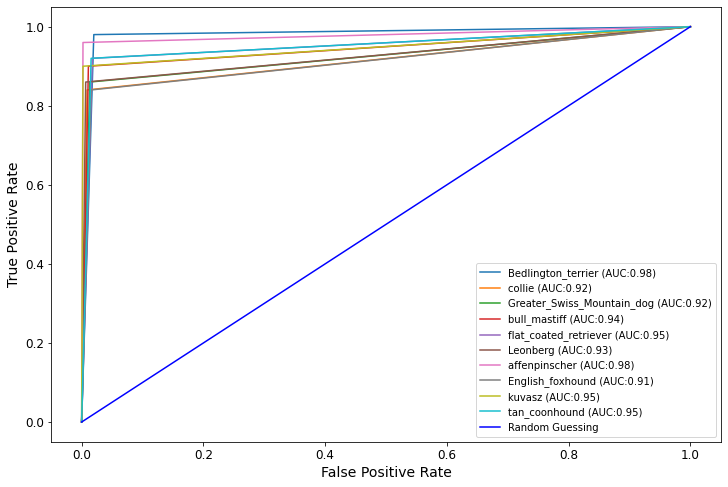

ROC AUC score: 0.9433333333333331


In [30]:
print('ROC AUC score:',
multiclass_roc_auc_score(new_model,
                         valid_dataset,
                         valid_labels,
                         dog_race_dict.keys(),
                         average="macro")
     )

## Stratégie extraction des features (model 2)

### Modèle

In [21]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model,callbacks
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=True, input_shape=(image_size, image_size, 3))

# Récupérer la sortie de ce réseau
x = model.layers[-2].output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes

predictions = Dense(num_classes, activation='softmax')(x)

# Stratégie #2 : extraction de features
for layer in model.layers[:-1]:
    layer.trainable = False

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)


In [22]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy",f1_m,precision_m,recall_m])
new_model.save_weights('model.h5')
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Entraînement

In [23]:
%time
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit(preprocess_input(train_dataset),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=10,
                           batch_size=32,
                           #verbose=2,
                           validation_data=(preprocess_input(valid_dataset),valid_labels_categorical)
                           )

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs
Epoch 1/10
63/63 [==============================] - 38s 478ms/step - loss: 0.6908 - accuracy: 0.8345 - f1_m: 0.8372 - precision_m: 0.8476 - recall_m: 0.8289 - val_loss: 0.4316 - val_accuracy: 0.8900 - val_f1_m: 0.8816 - val_precision_m: 0.8834 - val_recall_m: 0.8799
Epoch 2/10
63/63 [==============================] - 22s 344ms/step - loss: 0.1390 - accuracy: 0.9555 - f1_m: 0.9548 - precision_m: 0.9562 - recall_m: 0.9534 - val_loss: 0.2779 - val_accuracy: 0.9270 - val_f1_m: 0.9268 - val_precision_m: 0.9289 - val_recall_m: 0.9248
Epoch 3/10
63/63 [==============================] - 22s 349ms/step - loss: 0.0475 - accuracy: 0.9835 - f1_m: 0.9841 - precision_m: 0.9846 - recall_m: 0.9836 - val_loss: 0.2562 - val_accuracy: 0.9290 - val_f1_m: 0.9242 - val_precision_m: 0.9267 - val_recall_m: 0.9219
Epoch 4/10
63/63 [==============================] - 24s 382ms/step - loss: 0.0201 - accuracy: 0.9955 - f1_m: 0.9955 - precision_m: 0.99

### Résultats

Saving figure model2 val_loss min=0.20364 training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

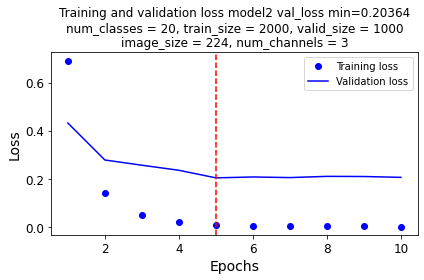

Saving figure model2 val_acc_max=0.945 training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

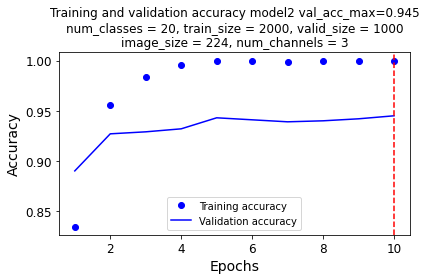

In [29]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min),loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max) ,acc_max=acc_max_epoch)

In [30]:

clas_report(new_model,valid_dataset,valid_labels)

Classification Report
                            precision    recall  f1-score   support

        Bedlington_terrier       0.96      1.00      0.98        50
                    collie       0.84      0.92      0.88        50
Greater_Swiss_Mountain_dog       0.95      0.82      0.88        50
              bull_mastiff       0.79      0.74      0.76        50
     flat_coated_retriever       0.57      0.96      0.72        50
                  Leonberg       0.96      0.50      0.66        50
             affenpinscher       0.81      0.94      0.87        50
          English_foxhound       0.82      0.80      0.81        50
                    kuvasz       0.83      0.78      0.80        50
             tan_coonhound       0.52      0.22      0.31        50
                bloodhound       0.79      0.46      0.58        50
           Norfolk_terrier       0.83      0.68      0.75        50
            Great_Pyrenees       0.68      0.92      0.78        50
            haired_pointe

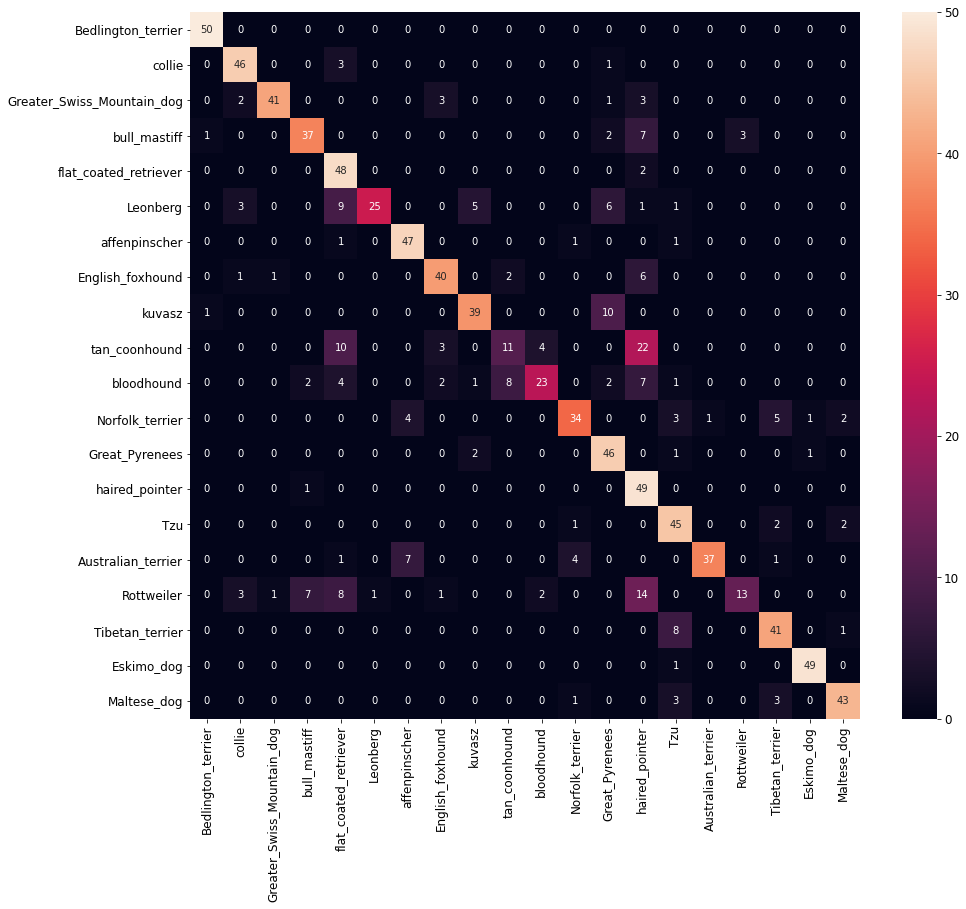

In [31]:
conf_matr(new_model,valid_dataset,valid_labels)

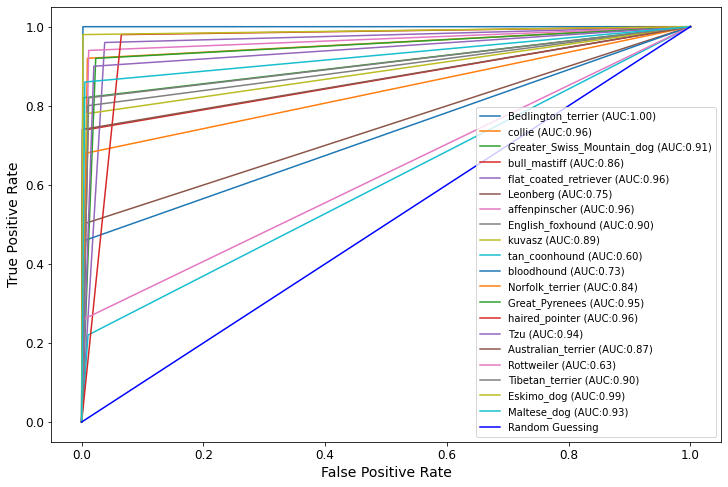

ROC AUC score: 0.8757894736842106


In [32]:
print('ROC AUC score:',
multiclass_roc_auc_score(new_model,
                         valid_dataset,
                         valid_labels,
                         dog_race_dict.keys(),
                         average="macro")
     )

## Whitening (model2)

### reduction dimention du dataset

In [27]:
train_dataset_reduced = np.zeros((train_dataset_white.shape))
train_dataset_temp = np.zeros((train_dataset_white.shape[0],
                              train_dataset_white.shape[1]//4,
                              train_dataset_white.shape[2]//4,
                              train_dataset_white.shape[3]))
for i in range(len(train_dataset)):
        train_dataset_temp[i] = resize(train_dataset_white[i], 
                                       (train_dataset_white.shape[1]//4,
                                        train_dataset_white.shape[2]//4))
        train_dataset_reduced[i] = resize(train_dataset_temp[i], 
                                          (train_dataset_white.shape[1],
                                           train_dataset_white.shape[2]))

In [28]:
valid_dataset_reduced = np.zeros((valid_dataset_white.shape))
valid_dataset_temp = np.zeros((valid_dataset_white.shape[0],
                              valid_dataset_white.shape[1]//4,
                              valid_dataset_white.shape[2]//4,
                              valid_dataset_white.shape[3]))
for i in range(len(valid_dataset)):
        valid_dataset_temp[i] = resize(valid_dataset_white[i], 
                                       (valid_dataset_white.shape[1]//4,
                                        valid_dataset_white.shape[2]//4))
        valid_dataset_reduced[i] = resize(valid_dataset_temp[i], 
                                          (valid_dataset_white.shape[1],
                                           valid_dataset_white.shape[2]))

### création du dataset avec whitening

In [29]:
ZCA_train_dataset,_,_,_ = zca_whitening_dataset(train_dataset_white,1000,factor=4,make_matrix=False,U=U,S=S,V=V)
ZCA_valid_dataset,_,_,_ = zca_whitening_dataset(valid_dataset_white,500,factor=4,make_matrix=False,U=U,S=S,V=V)

(1000, 224, 224, 3)
(1000, 224, 224, 3)
(1000, 56, 56, 3)
(1000, 9408)
X.min() -0.48501960903990504
X.max() 0.5923960966222427
(9408, 9408) (9408,)
(1000, 9408)
(1000, 56, 56, 3)
min: 11.987686136674434
max: 238.30805684054442
(500, 224, 224, 3)
(500, 224, 224, 3)
(500, 56, 56, 3)
(500, 9408)
X.min() -0.48501960903990504
X.max() 0.5923960966222427
(9408, 9408) (9408,)
(500, 9408)
(500, 56, 56, 3)
min: 9.929299869725556
max: 237.18226346416975


In [30]:
train_dataset_white[1, :]

array([[[-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939],
        ...,
        [-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939]],

       [[-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939],
        ...,
        [-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939]],

       [[-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939],
        ...,
        [-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939]],

       ...,

       [[-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939],
        ...,
        [-123.68 , -116.779, -103.939],
        [-123.68 , -116.779, -103.939],
        [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


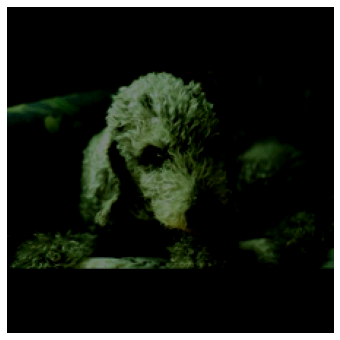

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


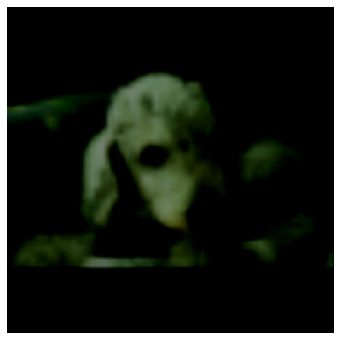

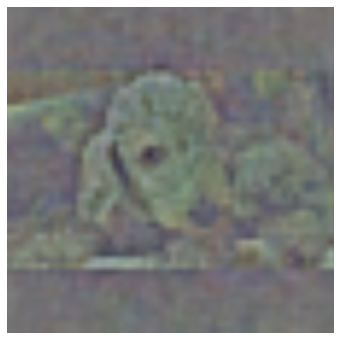

In [31]:
plotImage(train_dataset_white[1, :]/255)
plotImage(train_dataset_reduced[1, :]/255)
plotImage(ZCA_train_dataset[1, :]/255)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


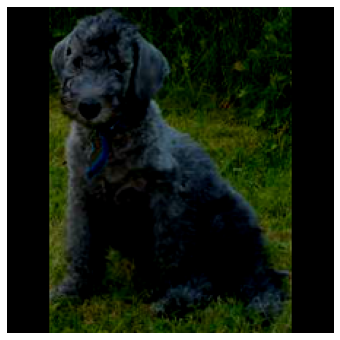

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


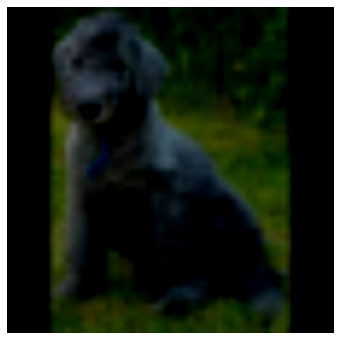

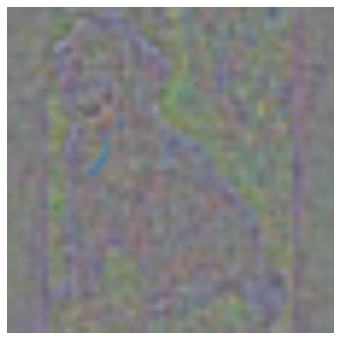

In [32]:
plotImage(valid_dataset[1, :]/255)
plotImage(valid_dataset_reduced[1, :]/255)
plotImage(ZCA_valid_dataset[1, :]/255)

In [33]:
preprocess_input(train_dataset_reduced)
preprocess_input(valid_dataset_reduced)

array([[[[-207.87800299, -233.55799933, -247.36000031],
         [-207.87800299, -233.55799933, -247.36000031],
         [-207.87800299, -233.55799933, -247.36000031],
         ...,
         [-207.87800299, -233.55799933, -247.36000031],
         [-207.87800299, -233.55799933, -247.36000031],
         [-207.87800299, -233.55799933, -247.36000031]],

        [[-207.87800299, -233.55799933, -247.36000031],
         [-207.87800299, -233.55799933, -247.36000031],
         [-207.87800299, -233.55799933, -247.36000031],
         ...,
         [-207.87800299, -233.55799933, -247.36000031],
         [-207.87800299, -233.55799933, -247.36000031],
         [-207.87800299, -233.55799933, -247.36000031]],

        [[-207.87800299, -233.55799933, -247.36000031],
         [-207.87800299, -233.55799933, -247.36000031],
         [-207.87800299, -233.55799933, -247.36000031],
         ...,
         [-207.87800299, -233.55799933, -247.36000031],
         [-207.87800299, -233.55799933, -247.36000031],
  

In [34]:
preprocess_input(ZCA_train_dataset)
preprocess_input(ZCA_valid_dataset)

array([[[[ 2.26996784e+01,  9.42666200e+00,  2.43040386e+00],
         [ 2.50981641e+01,  1.21263597e+01,  5.04890123e+00],
         [ 2.50981641e+01,  1.21263597e+01,  5.04890123e+00],
         ...,
         [ 2.74017872e+01,  1.10714634e+01,  2.92232249e+00],
         [ 2.74017872e+01,  1.10714634e+01,  2.92232249e+00],
         [ 2.70329696e+01,  9.94024542e+00,  1.51909045e+00]],

        [[ 2.23936615e+01,  8.50386261e+00,  1.15453886e+00],
         [ 2.45389943e+01,  1.11070718e+01,  3.68649945e+00],
         [ 2.45389943e+01,  1.11070718e+01,  3.68649945e+00],
         ...,
         [ 2.56930598e+01,  9.92744196e+00,  1.99541170e+00],
         [ 2.56930598e+01,  9.92744196e+00,  1.99541170e+00],
         [ 2.51445232e+01,  8.75288808e+00,  4.69333226e-01]],

        [[ 2.23936615e+01,  8.50386261e+00,  1.15453886e+00],
         [ 2.45389943e+01,  1.11070718e+01,  3.68649945e+00],
         [ 2.45389943e+01,  1.11070718e+01,  3.68649945e+00],
         ...,
         [ 2.56930598e+0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


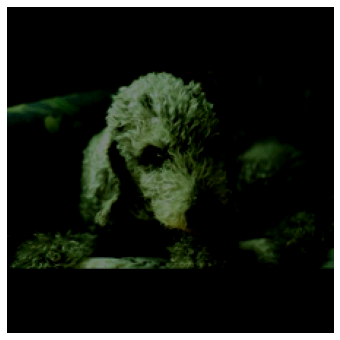

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


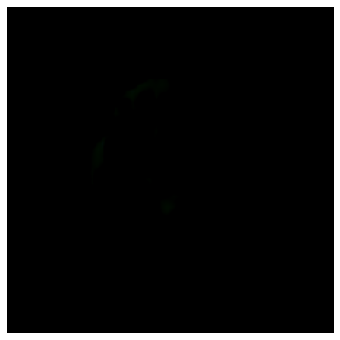

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


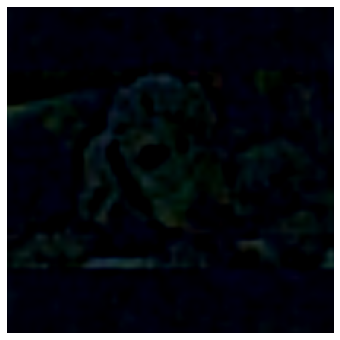

In [35]:
plotImage(train_dataset[1, :]/255)
plotImage(train_dataset_reduced[1, :]/255)
plotImage(ZCA_train_dataset[1, :]/255)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


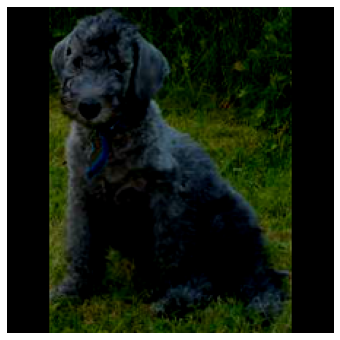

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


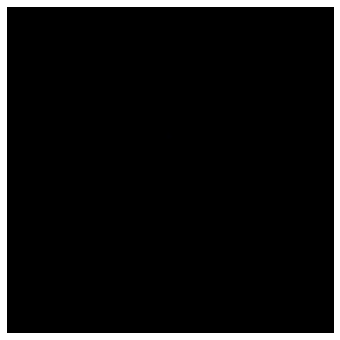

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


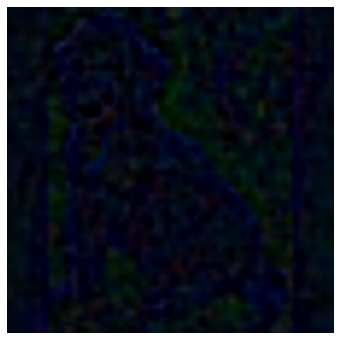

In [36]:
plotImage(valid_dataset[1, :]/255)
plotImage(valid_dataset_reduced[1, :]/255)
plotImage(ZCA_valid_dataset[1, :]/255)

### Entraînement avant whitening

In [70]:
%time
new_model.load_weights('model.h5')
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit((train_dataset_reduced),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=10,
                           batch_size=32,
                           #verbose=2,
                           validation_data=((valid_dataset_reduced),valid_labels_categorical)
                           )

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs
Epoch 1/10
32/32 [==============================] - 12s 347ms/step - loss: 1.1443 - accuracy: 0.6240 - f1_m: 0.6121 - precision_m: 0.7217 - recall_m: 0.5498 - val_loss: 0.6747 - val_accuracy: 0.7900 - val_f1_m: 0.7884 - val_precision_m: 0.8344 - val_recall_m: 0.7488
Epoch 2/10
32/32 [==============================] - 11s 334ms/step - loss: 0.3301 - accuracy: 0.8900 - f1_m: 0.8907 - precision_m: 0.9183 - recall_m: 0.8652 - val_loss: 0.6206 - val_accuracy: 0.8040 - val_f1_m: 0.8031 - val_precision_m: 0.8408 - val_recall_m: 0.7699
Epoch 3/10
32/32 [==============================] - 11s 336ms/step - loss: 0.1808 - accuracy: 0.9520 - f1_m: 0.9531 - precision_m: 0.9697 - recall_m: 0.9375 - val_loss: 0.5892 - val_accuracy: 0.8120 - val_f1_m: 0.8120 - val_precision_m: 0.8402 - val_recall_m: 0.7867
Epoch 4/10
32/32 [==============================] - 11s 338ms/step - loss: 0.1208 - accuracy: 0.9770 - f1_m: 0.9746 - precision_m: 

### Résultat avant whitenning

Saving figure model2 val_loss min=0.58916
images downsizés avant Whitening training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

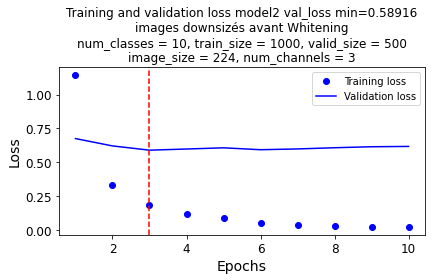

Saving figure model2 val_acc_max=0.836
images downsizés avant Whitening training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

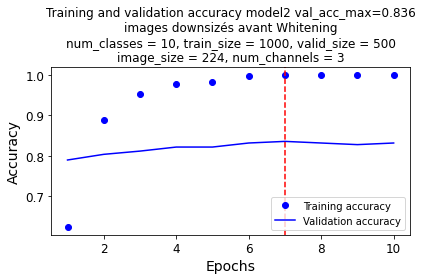

In [71]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min)+'\n'+'images downsizés avant Whitening',loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max)+'\n'+'images downsizés avant Whitening',acc_max=acc_max_epoch)

### Entraînement après whitennning

In [37]:
%time
new_model.load_weights('model.h5')
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit((ZCA_train_dataset),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=10,
                           batch_size=32,
                           #verbose=2,
                           validation_data=((ZCA_valid_dataset),valid_labels_categorical)
                           )

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.68 µs
Epoch 1/10
32/32 [==============================] - 29s 655ms/step - loss: 2.1318 - accuracy: 0.2850 - f1_m: 0.1808 - precision_m: 0.5008 - recall_m: 0.1143 - val_loss: 2.4592 - val_accuracy: 0.2340 - val_f1_m: 0.0874 - val_precision_m: 0.4125 - val_recall_m: 0.0508
Epoch 2/10
32/32 [==============================] - 11s 345ms/step - loss: 1.2622 - accuracy: 0.5640 - f1_m: 0.4876 - precision_m: 0.7782 - recall_m: 0.3604 - val_loss: 2.6530 - val_accuracy: 0.2160 - val_f1_m: 0.1279 - val_precision_m: 0.2567 - val_recall_m: 0.0859
Epoch 3/10
32/32 [==============================] - 11s 349ms/step - loss: 1.0433 - accuracy: 0.6590 - f1_m: 0.5930 - precision_m: 0.8195 - recall_m: 0.4678 - val_loss: 2.6610 - val_accuracy: 0.2340 - val_f1_m: 0.1328 - val_precision_m: 0.2994 - val_recall_m: 0.0879
Epoch 4/10
32/32 [==============================] - 11s 354ms/step - loss: 0.9032 - accuracy: 0.6910 - f1_m: 0.6527 - precision_m: 

### Résultat après whitening

Saving figure model2 val_loss min=2.45919
images downsizés avec Whitening training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

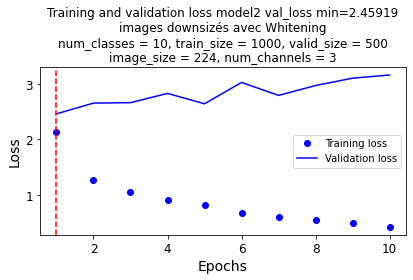

Saving figure model2 val_acc_max=0.256
images downsizés avec Whitening training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

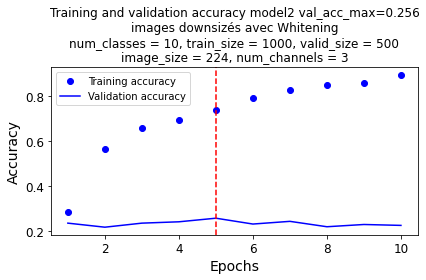

In [38]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min)+'\n'+'images downsizés avec Whitening',loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max)+'\n'+'images downsizés avec Whitening',acc_max=acc_max_epoch)

## CLAHE

## Preparation du dataset

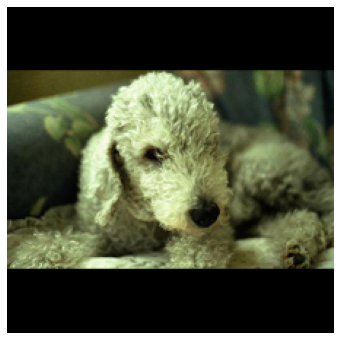

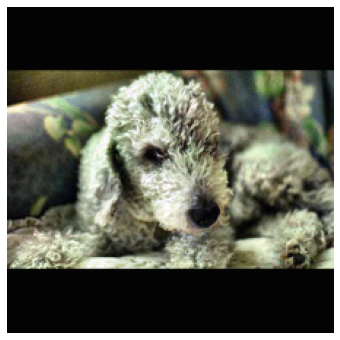

In [25]:
import cv2 as cv

# create a CLAHE object (Arguments are optional).
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img = (train_dataset_CLAHE[1,:,:,:].astype(np.uint8))

r,g,b = cv.split(img)

img[:,:,0] = clahe.apply(r)
img[:,:,1] = clahe.apply(g)
img[:,:,2] = clahe.apply(b)


plotImage((train_dataset_white[1,:,:,:].astype(np.uint8)))
plotImage(img)

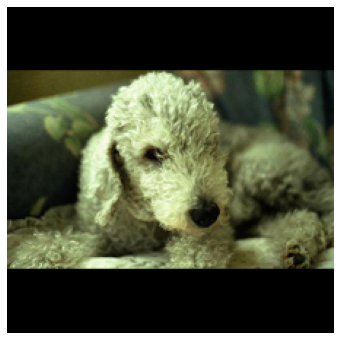

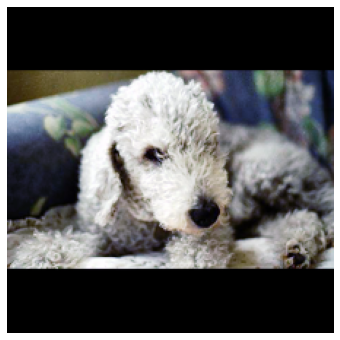

In [26]:
import cv2 as cv

img = (train_dataset_CLAHE[1,:,:,:].astype(np.uint8))

r,g,b = cv.split(img)

img[:,:,0] = cv.equalizeHist(r)
img[:,:,1] = cv.equalizeHist(g)
img[:,:,2] = cv.equalizeHist(b)

img.shape
plotImage((train_dataset_white[1,:,:,:].astype(np.uint8)))
plotImage(img)

In [27]:
import cv2 as cv

# create a CLAHE object (Arguments are optional).
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

train_dataset_EQUA =train_dataset_CLAHE.copy()
valid_dataset_EQUA = valid_dataset_CLAHE.copy()

for i in range(train_dataset_CLAHE.shape[0]):

    img = (train_dataset_CLAHE[i,:,:,:].astype(np.uint8))

    r,g,b = cv.split(img)

    train_dataset_CLAHE[i,:,:,0] = clahe.apply(r)
    train_dataset_CLAHE[i,:,:,1] = clahe.apply(g)
    train_dataset_CLAHE[i,:,:,2] = clahe.apply(b)
    
for i in range(valid_dataset_CLAHE.shape[0]):

    img = (valid_dataset_CLAHE[i,:,:,:].astype(np.uint8))

    r,g,b = cv.split(img)

    valid_dataset_CLAHE[i,:,:,0] = clahe.apply(r)
    valid_dataset_CLAHE[i,:,:,1] = clahe.apply(g)
    valid_dataset_CLAHE[i,:,:,2] = clahe.apply(b)

preprocess_input(train_dataset_CLAHE)
preprocess_input(valid_dataset_CLAHE)

array([[[[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ]],

        [[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ]],

        [[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ]],

        ...,

        [[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -1

In [28]:
import cv2 as cv



for i in range(train_dataset_EQUA.shape[0]):

    img = (train_dataset_EQUA[i,:,:,:].astype(np.uint8))

    r,g,b = cv.split(img)

    train_dataset_EQUA[i,:,:,0] = clahe.apply(r)
    train_dataset_EQUA[i,:,:,1] = clahe.apply(g)
    train_dataset_EQUA[i,:,:,2] = clahe.apply(b)
    
for i in range(valid_dataset_EQUA.shape[0]):

    img = (valid_dataset_EQUA[i,:,:,:].astype(np.uint8))

    r,g,b = cv.split(img)

    valid_dataset_EQUA[i,:,:,0] = clahe.apply(r)
    valid_dataset_EQUA[i,:,:,1] = clahe.apply(g)
    valid_dataset_EQUA[i,:,:,2] = clahe.apply(b)

preprocess_input(train_dataset_EQUA)
preprocess_input(valid_dataset_EQUA)

array([[[[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ]],

        [[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ]],

        [[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ]],

        ...,

        [[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -1

## Entraînement et résultats du modèle CLAHE

In [30]:
%time
new_model.load_weights('model.h5')
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit((train_dataset_CLAHE),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=10,
                           batch_size=32,
                           #verbose=2,
                           validation_data=((valid_dataset_CLAHE),valid_labels_categorical)
                           )

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs
Epoch 1/10
63/63 [==============================] - 38s 475ms/step - loss: 0.9230 - accuracy: 0.7305 - f1_m: 0.7266 - precision_m: 0.7657 - recall_m: 0.6999 - val_loss: 0.4497 - val_accuracy: 0.8640 - val_f1_m: 0.8624 - val_precision_m: 0.8775 - val_recall_m: 0.8486
Epoch 2/10
63/63 [==============================] - 22s 346ms/step - loss: 0.1865 - accuracy: 0.9370 - f1_m: 0.9361 - precision_m: 0.9441 - recall_m: 0.9286 - val_loss: 0.4238 - val_accuracy: 0.8610 - val_f1_m: 0.8564 - val_precision_m: 0.8688 - val_recall_m: 0.8447
Epoch 3/10
63/63 [==============================] - 22s 352ms/step - loss: 0.0776 - accuracy: 0.9770 - f1_m: 0.9773 - precision_m: 0.9810 - recall_m: 0.9737 - val_loss: 0.3678 - val_accuracy: 0.8770 - val_f1_m: 0.8811 - val_precision_m: 0.8907 - val_recall_m: 0.8721
Epoch 4/10
63/63 [==============================] - 24s 378ms/step - loss: 0.0376 - accuracy: 0.9955 - f1_m: 0.9945 - precision_m: 

Saving figure model2 val_loss min=0.35139
images avec CLAHE training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

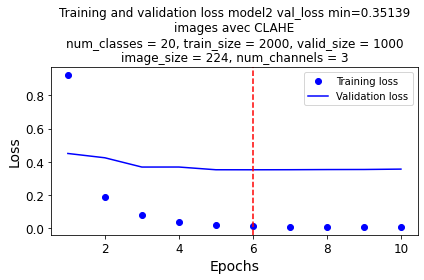

Saving figure model2 val_acc_max=0.883
images images avec CLAHE training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

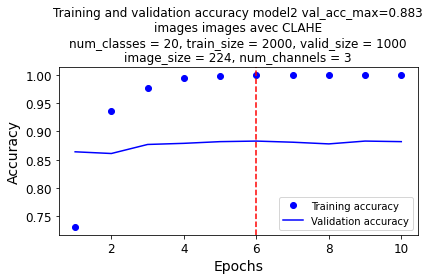

In [31]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min)+'\n'+'images avec CLAHE',loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max)+'\n'+'images images avec CLAHE',acc_max=acc_max_epoch)

## Entraînement et résultats du modèle EQUA

In [29]:
%time
new_model.load_weights('model.h5')
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit((train_dataset_EQUA),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=10,
                           batch_size=32,
                           #verbose=2,
                           validation_data=((valid_dataset_EQUA),valid_labels_categorical)
                           )

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs
Epoch 1/10
63/63 [==============================] - 38s 474ms/step - loss: 0.8179 - accuracy: 0.7600 - f1_m: 0.7553 - precision_m: 0.8056 - recall_m: 0.7217 - val_loss: 0.3769 - val_accuracy: 0.8740 - val_f1_m: 0.8758 - val_precision_m: 0.8915 - val_recall_m: 0.8613
Epoch 2/10
63/63 [==============================] - 22s 344ms/step - loss: 0.1768 - accuracy: 0.9420 - f1_m: 0.9426 - precision_m: 0.9506 - recall_m: 0.9350 - val_loss: 0.3691 - val_accuracy: 0.8840 - val_f1_m: 0.8845 - val_precision_m: 0.8957 - val_recall_m: 0.8740
Epoch 3/10
63/63 [==============================] - 22s 347ms/step - loss: 0.0861 - accuracy: 0.9715 - f1_m: 0.9733 - precision_m: 0.9770 - recall_m: 0.9697 - val_loss: 0.3630 - val_accuracy: 0.8920 - val_f1_m: 0.8910 - val_precision_m: 0.9007 - val_recall_m: 0.8818
Epoch 4/10
63/63 [==============================] - 23s 375ms/step - loss: 0.0411 - accuracy: 0.9900 - f1_m: 0.9901 - precision_m: 0.99

Saving figure model2 val_loss min=0.32726
images avec EQUALISATION training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

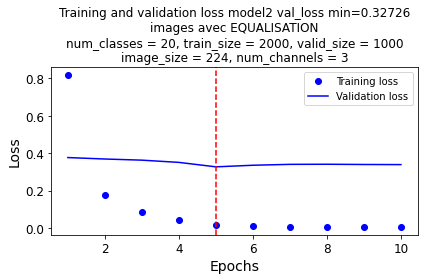

Saving figure model2 val_acc_max=0.896
images images avec EQUALISATION training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

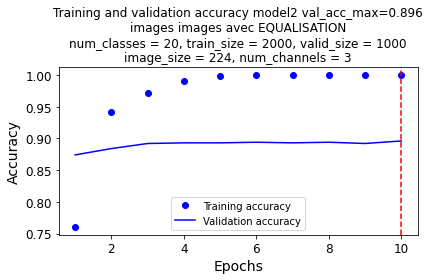

In [31]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min)+'\n'+'images avec EQUALISATION',loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max)+'\n'+'images images avec EQUALISATION',acc_max=acc_max_epoch)

## Ajout de data augmentation

### Exemple

In [27]:
from keras.preprocessing.image import ImageDataGenerator

datagen_chien = ImageDataGenerator(featurewise_center=False,
                                   samplewise_center=False,
                                   featurewise_std_normalization=False,
                                   samplewise_std_normalization=False,
                                   #preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Full dataset tensor: (152, 224, 224, 3)
Photo avant et après preprocess pour le modèle VGG-16
Exemple de Data Aumentation


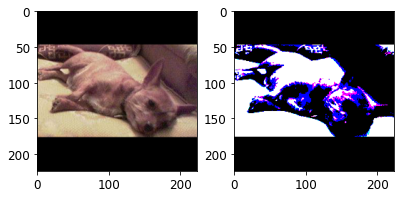

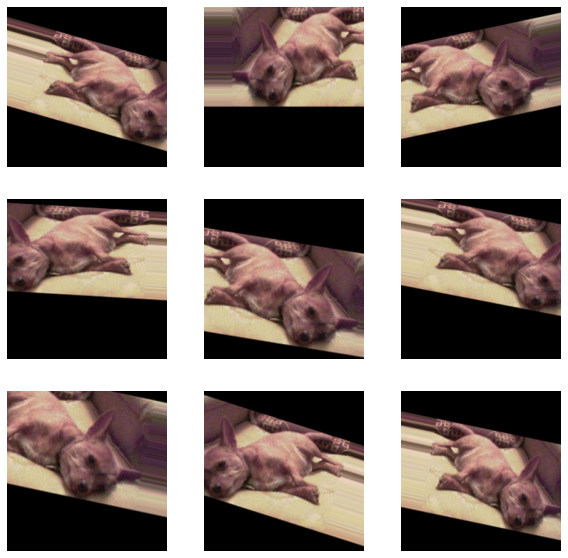

In [28]:
import tensorflow as tf

folder = 'data/Images/n02085620-Chihuahua'
dataset_chien = make_dataset_race(folder,preprocess=False)
image = dataset_chien[1,:,:,:]/255
#datagen_chien.fit(tf.expand_dims(image, 0))
print( 'Photo avant et après preprocess pour le modèle VGG-16')
plt.figure(figsize=(10, 10))
ax = plt.subplot(3, 3, 1)
plt.imshow(image)
ax = plt.subplot(3, 3, 2)
plt.imshow(preprocess_input(image*255))
plt.figure(figsize=(10, 10))
plt.axis('off')
print( 'Exemple de Data Aumentation')
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = datagen_chien.flow(tf.expand_dims(image, 0), batch_size=1)
    plt.imshow(augmented_image[0][0])
    plt.axis('off')



### Générateur

In [1]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=20,
                             #shear_range=0.2,
                             #zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest'
                             )
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
#datagen.fit(train_dataset) # pas nécessaire car les images sont déjà préprocessés


/home/fedecabre/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


### Entraînement

In [50]:
# reset the weights
new_model.load_weights('model.h5')

# fits the model on batches with real-time data augmentation:
model2da_info = new_model.fit(datagen.flow(train_dataset, 
                                           train_labels_categorical, 
                                           batch_size=32),
                                initial_epoch=0,
                                validation_data=(valid_dataset, valid_labels_categorical),
                                steps_per_epoch=32,
                                epochs=15)

ValueError: shapes (1,150528) and (7500,7500) not aligned: 150528 (dim 1) != 7500 (dim 0)

### Résultats model 2 avec Data Aumentation

Saving figure model2 avec DA val_loss min=0.2581 training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

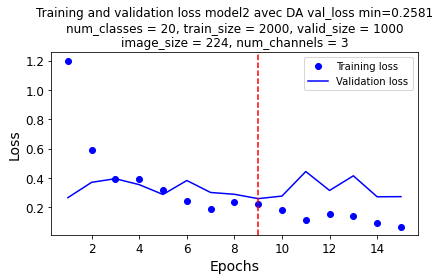

In [46]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2da_info)
plot_loss(model2da_info,'model2 avec DA val_loss min='+str(loss_min),loss_min=loss_min_epoch)
plot_accuracy(model2da_info,'model2 avec DA val_acc_max='+str(acc_max),acc_max=acc_max_epoch)

In [48]:

clas_report(new_model,valid_dataset,valid_labels)

Classification Report
                            precision    recall  f1-score   support

        Bedlington_terrier       0.98      1.00      0.99        50
                    collie       1.00      0.94      0.97        50
Greater_Swiss_Mountain_dog       1.00      1.00      1.00        50
              bull_mastiff       0.98      0.98      0.98        50
     flat_coated_retriever       0.98      0.98      0.98        50
                  Leonberg       1.00      0.98      0.99        50
             affenpinscher       1.00      0.96      0.98        50
          English_foxhound       0.98      0.96      0.97        50
                    kuvasz       0.89      0.82      0.85        50
             tan_coonhound       0.86      0.98      0.92        50
                bloodhound       0.92      0.92      0.92        50
           Norfolk_terrier       0.92      0.94      0.93        50
            Great_Pyrenees       0.79      0.90      0.84        50
            haired_pointe

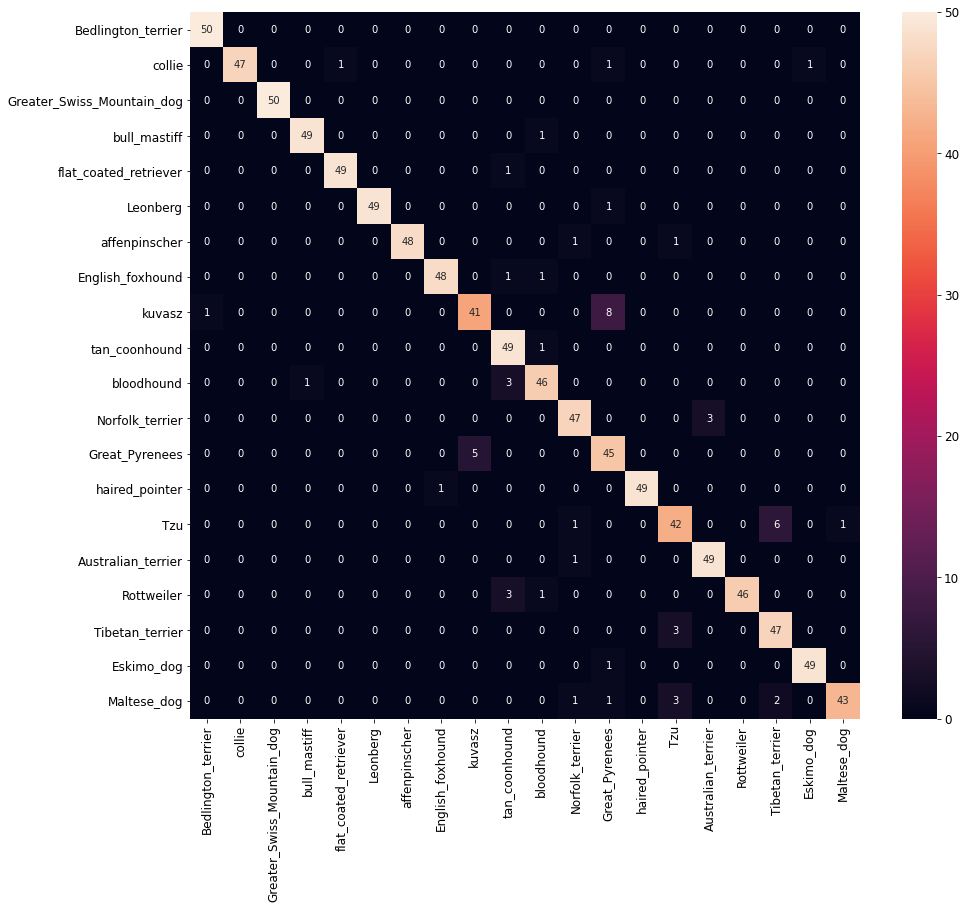

In [49]:
conf_matr(new_model,valid_dataset,valid_labels)

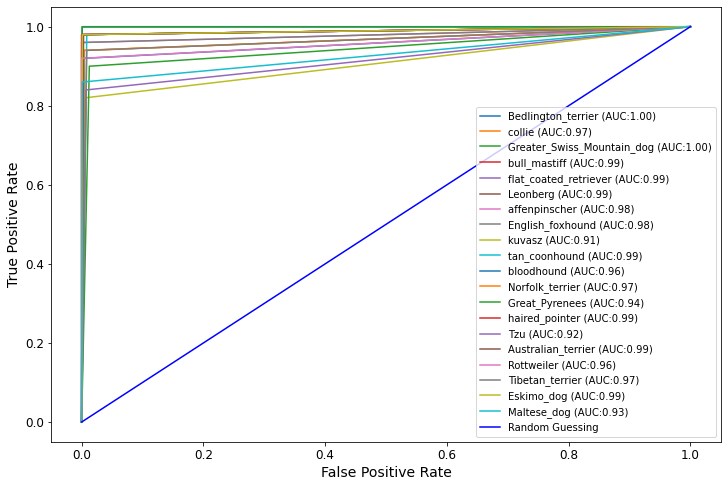

ROC AUC score: 0.97


In [50]:
print('ROC AUC score:',
multiclass_roc_auc_score(new_model,
                         valid_dataset,
                         valid_labels,
                         dog_race_dict.keys(),
                         average="macro")
     )

# Entrainement sur toutes les classes avec DA

## Création du générateur de données

In [23]:
from keras.preprocessing.image import ImageDataGenerator

crop_images_folders_path = project_path+"data/Cropped/"
image_size = 224
num_channels = 3

datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             validation_split=0.1,
                             rotation_range=20,
                             #shear_range=0.2,
                             #zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest'
                             )

train_generator = datagen.flow_from_directory(crop_images_folders_path,
                                                target_size=(image_size, image_size),
                                                batch_size=32,
                                                subset="training",
                                                class_mode='categorical')

validation_generator = datagen.flow_from_directory(crop_images_folders_path,
                                                   target_size=(image_size, image_size),
                                                   batch_size=32,
                                                   subset="validation",
                                                   class_mode='categorical')
num_classes = train_generator.num_classes
train_size = train_generator.n
valid_size = validation_generator.n

Found 18570 images belonging to 120 classes.
Found 2009 images belonging to 120 classes.


## Modèle avec nombre de classes 120

In [24]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model,callbacks
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# Récupérer la sortie de ce réseau
x = model.layers[-2].output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes

predictions = Dense(num_classes, activation='softmax')(x)

# Stratégie #2 : extraction de features
for layer in model.layers[:-1]:
    layer.trainable = False

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)


In [26]:
import tensorflow as tf
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=["accuracy",f1_m,precision_m,recall_m])

new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## entraînement

In [27]:
model2_120_info = new_model.fit(train_generator,
                                validation_data=validation_generator,
                                initial_epoch=0,
                                steps_per_epoch=64,
                                epochs=50)

Epoch 1/50
64/64 [==============================] - 53s 721ms/step - loss: 4.3557 - accuracy: 0.1273 - f1_m: 0.0428 - precision_m: 0.3448 - recall_m: 0.0234 - val_loss: 2.8106 - val_accuracy: 0.2977 - val_f1_m: 0.1322 - val_precision_m: 0.6351 - val_recall_m: 0.0755
Epoch 2/50
64/64 [==============================] - 36s 565ms/step - loss: 2.1175 - accuracy: 0.4399 - f1_m: 0.2801 - precision_m: 0.7529 - recall_m: 0.1768 - val_loss: 1.6960 - val_accuracy: 0.5381 - val_f1_m: 0.4092 - val_precision_m: 0.7990 - val_recall_m: 0.2795
Epoch 3/50
64/64 [==============================] - 49s 772ms/step - loss: 1.4448 - accuracy: 0.5898 - f1_m: 0.4680 - precision_m: 0.8060 - recall_m: 0.3354 - val_loss: 1.3145 - val_accuracy: 0.6242 - val_f1_m: 0.5410 - val_precision_m: 0.8262 - val_recall_m: 0.4076
Epoch 4/50
64/64 [==============================] - 52s 817ms/step - loss: 1.1480 - accuracy: 0.6685 - f1_m: 0.6143 - precision_m: 0.8522 - recall_m: 0.4849 - val_loss: 1.1439 - val_accuracy: 0.6695 

Epoch 32/50
64/64 [==============================] - 40s 625ms/step - loss: 0.4898 - accuracy: 0.8477 - f1_m: 0.8455 - precision_m: 0.8973 - recall_m: 0.8008 - val_loss: 0.7358 - val_accuracy: 0.7745 - val_f1_m: 0.7755 - val_precision_m: 0.8315 - val_recall_m: 0.7279
Epoch 33/50
64/64 [==============================] - 39s 616ms/step - loss: 0.4833 - accuracy: 0.8389 - f1_m: 0.8430 - precision_m: 0.8866 - recall_m: 0.8047 - val_loss: 0.7168 - val_accuracy: 0.7750 - val_f1_m: 0.7758 - val_precision_m: 0.8281 - val_recall_m: 0.7308
Epoch 34/50
64/64 [==============================] - 40s 627ms/step - loss: 0.4833 - accuracy: 0.8394 - f1_m: 0.8350 - precision_m: 0.8845 - recall_m: 0.7920 - val_loss: 0.7115 - val_accuracy: 0.7845 - val_f1_m: 0.7859 - val_precision_m: 0.8408 - val_recall_m: 0.7400
Epoch 35/50
64/64 [==============================] - 39s 616ms/step - loss: 0.4858 - accuracy: 0.8428 - f1_m: 0.8393 - precision_m: 0.8826 - recall_m: 0.8013 - val_loss: 0.7305 - val_accuracy: 0.7

## Résultats

Saving figure model2 val_loss min=0.68316 training_and_validation_accuracy-num_classes=120-train_size=18570-valid_size=2009-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

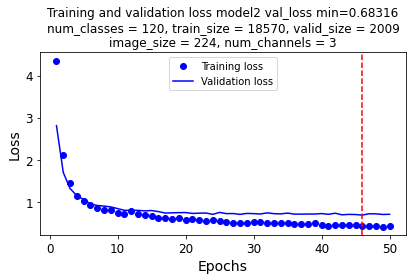

In [28]:

loss_min, loss_min_epoch, _, _ = min_loss_max_acc(model2_120_info)
plot_loss(model2_120_info,'model2 val_loss min='+str(loss_min),loss_min=loss_min_epoch)


Saving figure model2 avec DA val_acc_max=0.78795 training_and_validation_accuracy-num_classes=120-train_size=18570-valid_size=2009-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

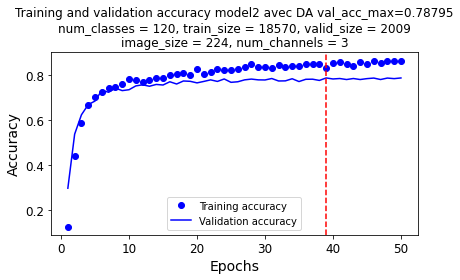

In [29]:
_, _, acc_max, acc_max_epoch = min_loss_max_acc(model2_120_info)
plot_accuracy(model2_120_info,'model2 avec DA val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


In [30]:
validation_generator2 = datagen.flow_from_directory(crop_images_folders_path,
                                                   target_size=(image_size, image_size),
                                                   batch_size=1500,
                                                   subset="validation",
                                                   class_mode='categorical')

(images,labels) = next(validation_generator2)

Found 2009 images belonging to 120 classes.


In [31]:
labels2=np.zeros(labels.shape[0])
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        if labels[i,j]==1:
            labels2[i]=j
            
# tester Argmax 

In [32]:

clas_report(new_model,images,labels2,validation_generator.class_indices)

Classification Report
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.73      0.80      0.76        10
              n02085782-Japanese_spaniel       0.78      0.93      0.85        15
                   n02085936-Maltese_dog       0.91      0.95      0.93        22
                      n02086079-Pekinese       0.75      0.90      0.82        10
                      n02086240-Shih-Tzu       0.57      0.75      0.65        16
              n02086646-Blenheim_spaniel       0.88      1.00      0.94        15
                      n02086910-papillon       0.75      0.60      0.67        10
                   n02087046-toy_terrier       0.82      0.69      0.75        13
           n02087394-Rhodesian_ridgeback       0.90      0.90      0.90        10
                  n02088094-Afghan_hound       0.86      0.95      0.90        19
                        n02088238-basset       0.53      0.80      0.64    

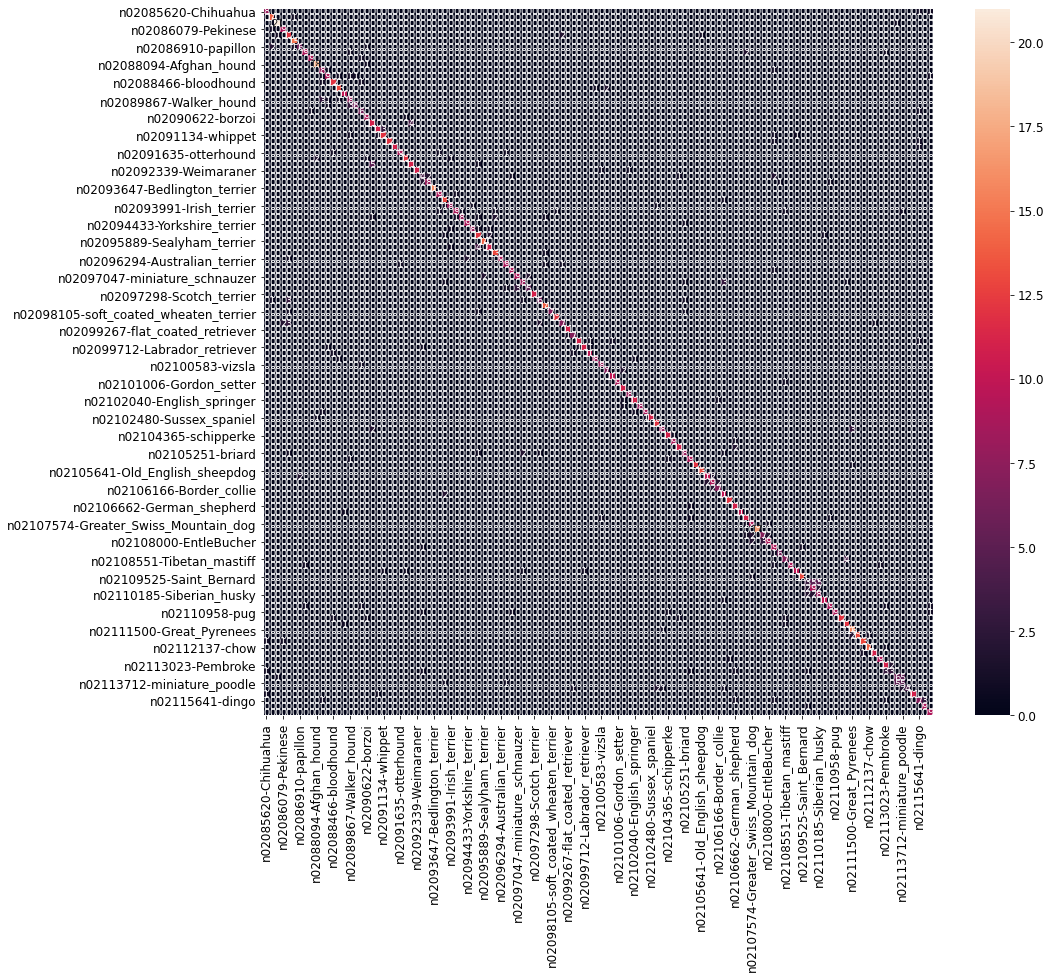

In [33]:
conf_matr(new_model,images,labels2,validation_generator.class_indices)

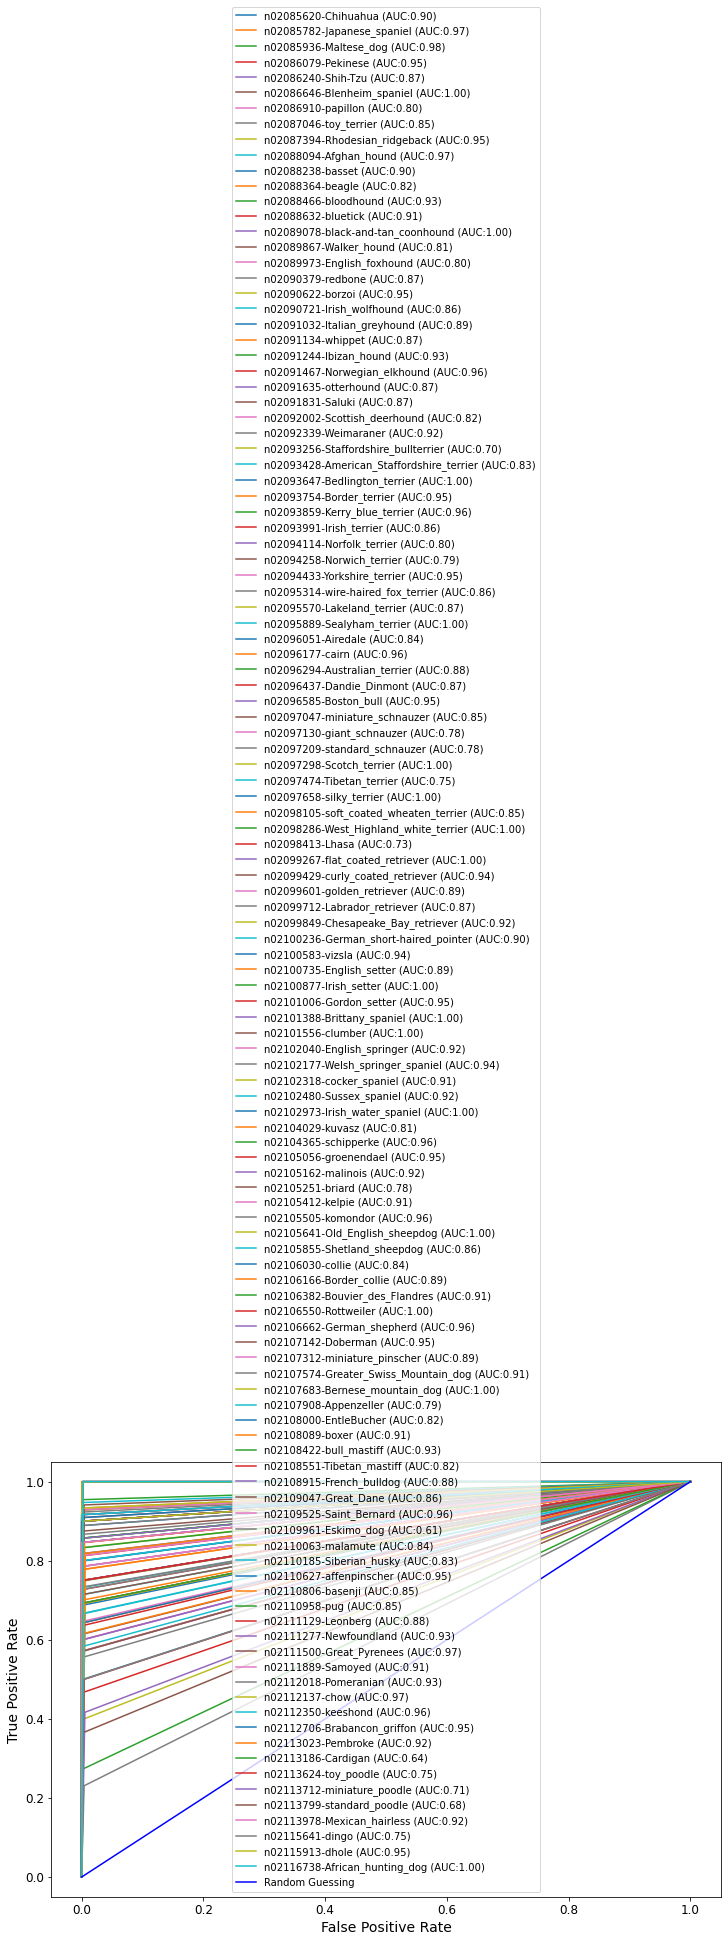

ROC AUC score: 0.8934150797842009


In [34]:
print('ROC AUC score:',
multiclass_roc_auc_score(new_model,
                         images,
                         labels2,
                         validation_generator.class_indices.keys(),
                         validation_generator.class_indices,
                         average="macro")
     )

## Fine tunning

In [35]:
for layer in new_model.layers[-2:-1]:
    layer.trainable = True
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [36]:
model2ft_120_info = new_model.fit(train_generator,
                                validation_data=validation_generator,
                                initial_epoch=50,
                                steps_per_epoch=64,
                                epochs=100)

Epoch 51/100
64/64 [==============================] - 33s 524ms/step - loss: 0.3921 - accuracy: 0.8687 - f1_m: 0.8742 - precision_m: 0.9133 - recall_m: 0.8394 - val_loss: 0.7417 - val_accuracy: 0.7745 - val_f1_m: 0.7763 - val_precision_m: 0.8265 - val_recall_m: 0.7333
Epoch 52/100
64/64 [==============================] - 34s 534ms/step - loss: 0.4289 - accuracy: 0.8599 - f1_m: 0.8611 - precision_m: 0.9015 - recall_m: 0.8252 - val_loss: 0.6991 - val_accuracy: 0.7939 - val_f1_m: 0.7915 - val_precision_m: 0.8385 - val_recall_m: 0.7507
Epoch 53/100
64/64 [==============================] - 35s 550ms/step - loss: 0.3962 - accuracy: 0.8687 - f1_m: 0.8591 - precision_m: 0.9008 - recall_m: 0.8228 - val_loss: 0.7250 - val_accuracy: 0.7815 - val_f1_m: 0.7846 - val_precision_m: 0.8278 - val_recall_m: 0.7469
Epoch 54/100
64/64 [==============================] - 35s 551ms/step - loss: 0.3807 - accuracy: 0.8766 - f1_m: 0.8704 - precision_m: 0.9048 - recall_m: 0.8396 - val_loss: 0.7132 - val_accuracy:

64/64 [==============================] - 35s 551ms/step - loss: 0.3287 - accuracy: 0.8926 - f1_m: 0.8927 - precision_m: 0.9205 - recall_m: 0.8672 - val_loss: 0.7061 - val_accuracy: 0.7860 - val_f1_m: 0.7924 - val_precision_m: 0.8289 - val_recall_m: 0.7599
Epoch 82/100
64/64 [==============================] - 35s 551ms/step - loss: 0.3032 - accuracy: 0.8963 - f1_m: 0.8969 - precision_m: 0.9272 - recall_m: 0.8694 - val_loss: 0.7279 - val_accuracy: 0.7830 - val_f1_m: 0.7885 - val_precision_m: 0.8249 - val_recall_m: 0.7561
Epoch 83/100
64/64 [==============================] - 35s 551ms/step - loss: 0.3159 - accuracy: 0.8931 - f1_m: 0.8927 - precision_m: 0.9236 - recall_m: 0.8647 - val_loss: 0.6981 - val_accuracy: 0.7899 - val_f1_m: 0.7926 - val_precision_m: 0.8302 - val_recall_m: 0.7594
Epoch 84/100
64/64 [==============================] - 35s 551ms/step - loss: 0.3017 - accuracy: 0.8968 - f1_m: 0.8952 - precision_m: 0.9234 - recall_m: 0.8696 - val_loss: 0.7333 - val_accuracy: 0.7954 - val

In [39]:
new_model.save_weights(project_path+'models/model120_weights.h5')

In [40]:
new_model.save(project_path+'models/model120.h5')

## Résultats

Saving figure model2 val_loss min=0.69065 training_and_validation_accuracy-num_classes=120-train_size=18570-valid_size=2009-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

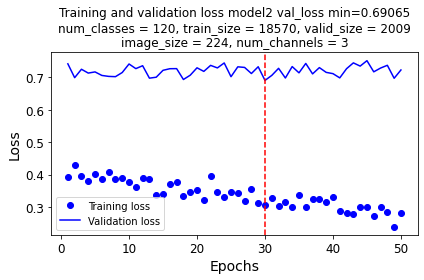

Saving figure model2 avec DA val_acc_max=0.79791 training_and_validation_accuracy-num_classes=120-train_size=18570-valid_size=2009-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

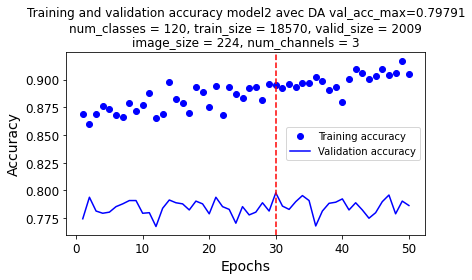

In [49]:

loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2ft_120_info)

plot_loss(model2ft_120_info,'model2 val_loss min='+str(loss_min),loss_min=loss_min_epoch)
plot_accuracy(model2ft_120_info,'model2 avec DA val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


In [42]:
acc = [0.] + model2_120_info.history['accuracy']
val_acc = [0.] + model2_120_info.history['val_accuracy']

loss = model2_120_info.history['loss']
val_loss = model2_120_info.history['val_loss']


acc += model2ft_120_info.history['accuracy']
val_acc += model2ft_120_info.history['val_accuracy']

loss += model2ft_120_info.history['loss']
val_loss += model2ft_120_info.history['val_loss']

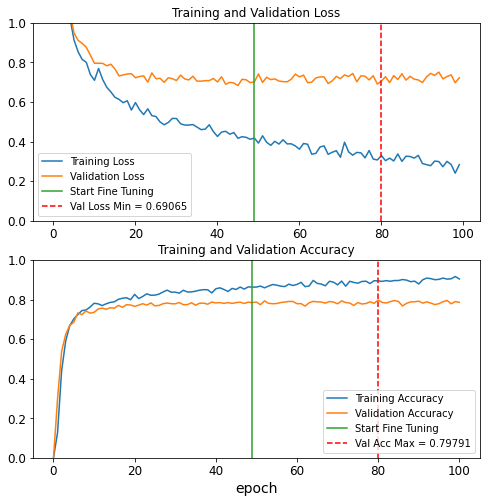

In [59]:
initial_epochs = 50
loss_min_epoch = initial_epochs + 30
acc_max_epoch = initial_epochs + 30

plt.figure(figsize=(8, 8)).patch.set_facecolor('w')
plt.axvline(x=loss_min,color='red',linestyle='--')
plt.subplot(2, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.axvline(x=acc_max_epoch,color='red',linestyle='--',label="Val Acc Max = "+str(acc_max))
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.axvline(x=loss_min_epoch,color='red',linestyle='--',label="Val Loss Min = "+str(loss_min))
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')


plt.show()